# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

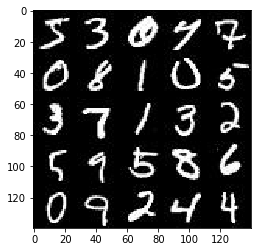

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

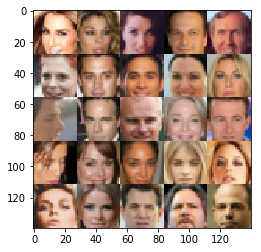

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    print("model_inputs",image_width, image_height, image_channels,z_dim)
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

model_inputs 28 28 3 100
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\mariu\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\mariu\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\mariu\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\mariu\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\mariu\\AppData\\Local\\conda\\

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [108]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    print("discriminator", images, reuse)
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
#         x1 = tf.layers.batch_normalization(x1, training= True)
#         x1 = tf.nn.relu(x1) - alpha * tf.nn.relu(-x1)
#         x1 = tf.nn.relu(x1)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1)
        
        # 14x14x128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=True)
#         x2 = tf.nn.relu(x2) - alpha * tf.nn.relu(-x2)
#         x2 = tf.nn.relu(x2)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2)
        
        # 7x7x256
        
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=True)
#         x3 = tf.nn.relu(x3) - alpha * tf.nn.relu(-x3)
#         x3 = tf.nn.relu(x3)
        x3 = tf.maximum(alpha * x3, x3)
#         x3 = tf.layers.dropout(x3,training=reuse)
        
        # 4x4x512
        
        # Flatten it
        unused,x,y,d = x3.shape
        size = int(x*y*d)
        flat = tf.reshape(x3, (-1, size))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
#     return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

discriminator Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32) False
discriminator Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32) True
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [110]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    print("generator",z, out_channel_dim, is_train)
    alpha = 0.1
    print(out_channel_dim)
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        dense = tf.layers.dense(z, 7*7*1024)
        
        
        # Reshape it to start the convolutional stack
        reshape = tf.reshape(dense, (-1, 7, 7, 1024))
        
        
        
        x1 = tf.layers.conv2d_transpose(reshape, 512, 5, strides=1, padding='same')
#         x1 = tf.layers.batch_normalization(reshape, training=is_train)
#         x1 = tf.nn.relu(x1) - alpha * tf.nn.relu(-x1)
#         x1 = tf.nn.relu(x1)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1,training=is_train)

        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.nn.relu(x2) - alpha * tf.nn.relu(-x2)
#         x2 = tf.nn.relu(x2)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2,training=is_train)
        
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.nn.relu(x3) - alpha * tf.nn.relu(-x3)
#         x3 = tf.nn.relu(x3)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3,training=is_train)

        # 14x14x128
    
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
#         x4 = tf.nn.relu(x4) - alpha * tf.nn.relu(-x4)
#         x4 = tf.nn.relu(x4)
        x4 = tf.maximum(alpha * x4, x4)
#         x4 = tf.layers.dropout(x4,training=is_train)

        # 14x14x64
        
#         x5 = tf.layers.conv2d_transpose(x4, 128, 5, strides=1, padding='same')
#         x5 = tf.layers.batch_normalization(x5, training=is_train)
#         x5 = tf.nn.relu(x5) - alpha * tf.nn.relu(-x5)
#         x5 = tf.nn.relu(x5)
#         x5 = tf.maximum(alpha * x5, x5)
        # 28x28x512 now
    
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out    
#     return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

generator Tensor("Placeholder:0", shape=(?, 100), dtype=float32) 5 True
5
generator Tensor("Placeholder:0", shape=(?, 100), dtype=float32) 5 False
5
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [111]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    print("model_loss",input_real, input_z, out_channel_dim)

    g_model = generator(input_z, out_channel_dim)
    print("g_model", g_model)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    
#     return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

model_loss Tensor("Placeholder:0", shape=(?, 28, 28, 4), dtype=float32) Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32) 4
generator Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32) 4 True
4
g_model Tensor("generator/Tanh:0", shape=(?, 28, 28, 4), dtype=float32)
discriminator Tensor("Placeholder:0", shape=(?, 28, 28, 4), dtype=float32) False
discriminator Tensor("generator/Tanh:0", shape=(?, 28, 28, 4), dtype=float32) True
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [112]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    print("model_opt", d_loss, g_loss, learning_rate, beta1)
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    
#     return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

model_opt Tensor("Mean:0", shape=(), dtype=float32) Tensor("Mean_1:0", shape=(), dtype=float32) 0.001 0.9
Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [113]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [119]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z,l_rate = model_inputs(*data_shape[1:4], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    print("=====",input_real)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    

    samples, losses = [], []
    steps = 0
    
    print("batch_size",batch_size)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                # TODO: Train Model
#                 print("batch_images",batch_images[0])
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate:learning_rate})

#                 if steps % 10 == 0:
                # At the end of each epoch, get the losses and print them out
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})

                if steps % 40 == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))

                if steps % 400 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                if steps % 400 == 0:
                    fig, ax = pyplot.subplots()
                    losses2 = np.array(losses)
                    pyplot.plot(losses2.T[0], label='Discriminator', alpha=0.5)
                    pyplot.plot(losses2.T[1], label='Generator', alpha=0.5)
                    pyplot.title("Training Losses")
                    pyplot.legend()
                    pyplot.show()
                    
        saver.save(sess, './checkpoints/generator.ckpt')

#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)

        show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)

        fig, ax = pyplot.subplots()
        losses2 = np.array(losses)
        pyplot.plot(losses2.T[0], label='Discriminator', alpha=0.5)
        pyplot.plot(losses2.T[1], label='Generator', alpha=0.5)
        pyplot.title("Training Losses")
        pyplot.legend()
        pyplot.show()
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

model_inputs 28 28 1 1024
model_loss Tensor("input_real:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 True
1
g_model Tensor("generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)
discriminator Tensor("input_real:0", shape=(?, 28, 28, 1), dtype=float32) False
discriminator Tensor("generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) True
===== Tensor("input_real:0", shape=(?, 28, 28, 1), dtype=float32)
model_opt Tensor("add:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) 0.0005 0.4
batch_size 32
Epoch 1/2... Discriminator Loss: 2.4716... Generator Loss: 0.1589
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 1.1652
Epoch 1/2... Discriminator Loss: 1.6436... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 2.4418... Generator Loss: 0.1260
Epoch 1/2... Discriminator Loss: 2.1911... Generator Loss: 0.1862
Epoch 1/2... Discriminator 

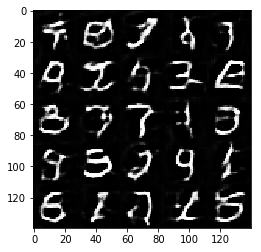

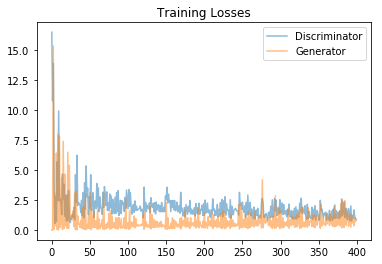

Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 1.4814
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.6470
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.5377
Epoch 1/2... Discriminator Loss: 0.7329... Generator Loss: 2.2838
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.6942... Generator Loss: 0.3936
Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 2.1636
Epoch 1/2... Discriminator Loss: 1.7165... Generator Loss: 0.2941
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


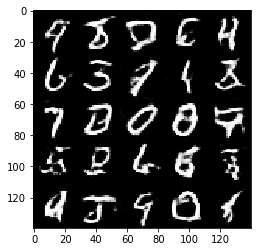

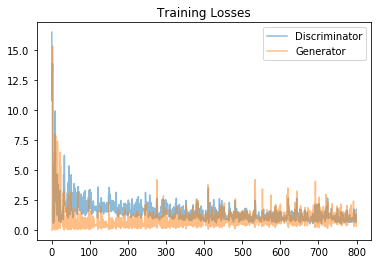

Epoch 1/2... Discriminator Loss: 2.5702... Generator Loss: 3.9503
Epoch 1/2... Discriminator Loss: 2.2427... Generator Loss: 0.2037
Epoch 1/2... Discriminator Loss: 0.5105... Generator Loss: 1.4802
Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 1.6892... Generator Loss: 0.3773
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.4859
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.6041
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 1.0176
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 1.1690
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


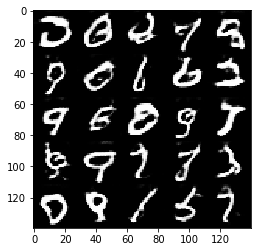

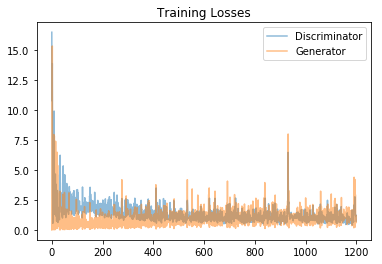

Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 1.0060... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 2.6450... Generator Loss: 0.1111
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.2099
Epoch 1/2... Discriminator Loss: 0.5830... Generator Loss: 1.6140
Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 0.5591... Generator Loss: 1.8857
Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 1.1858
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 0.7380
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


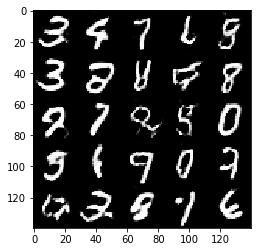

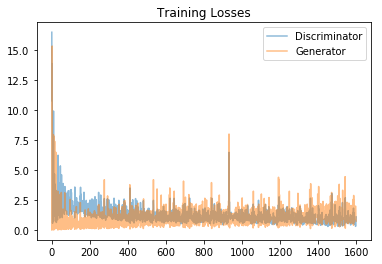

Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.0907
Epoch 1/2... Discriminator Loss: 0.2409... Generator Loss: 2.9385
Epoch 1/2... Discriminator Loss: 0.6467... Generator Loss: 2.2489
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 0.2838... Generator Loss: 2.1213
Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 0.9866
Epoch 2/2... Discriminator Loss: 0.5231... Generator Loss: 1.1640
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 0.6100... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 0.7905... Generator Loss: 1.4003
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


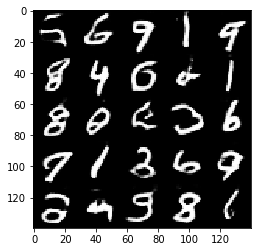

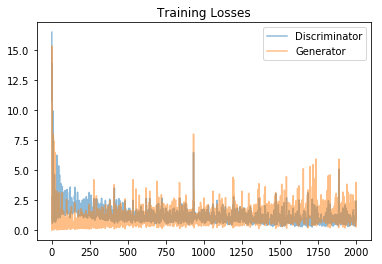

Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 2.2185... Generator Loss: 0.2475
Epoch 2/2... Discriminator Loss: 0.4074... Generator Loss: 2.2987
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 0.2860... Generator Loss: 1.6206
Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 2.1972
Epoch 2/2... Discriminator Loss: 0.4361... Generator Loss: 1.4678
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 0.3935... Generator Loss: 3.0142
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


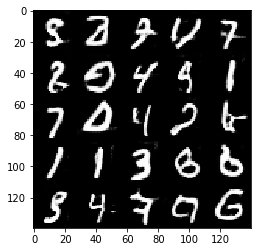

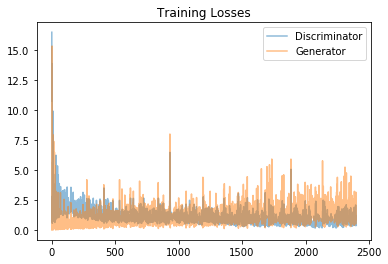

Epoch 2/2... Discriminator Loss: 2.6091... Generator Loss: 0.1854
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 1.2829
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.0154
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 2.2917
Epoch 2/2... Discriminator Loss: 0.6129... Generator Loss: 1.3254
Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 0.3967... Generator Loss: 1.3635
Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.9060
Epoch 2/2... Discriminator Loss: 4.0680... Generator Loss: 0.0671
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.4251
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


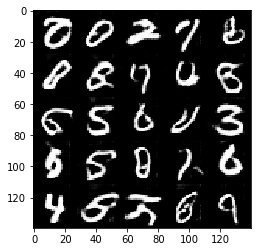

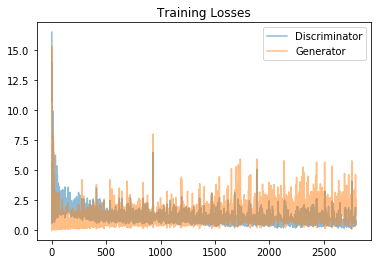

Epoch 2/2... Discriminator Loss: 0.4516... Generator Loss: 1.6332
Epoch 2/2... Discriminator Loss: 0.2483... Generator Loss: 2.5588
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 1.5769
Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 0.8975
Epoch 2/2... Discriminator Loss: 0.3913... Generator Loss: 1.9463
Epoch 2/2... Discriminator Loss: 0.3425... Generator Loss: 1.8154
Epoch 2/2... Discriminator Loss: 0.3903... Generator Loss: 2.2829
Epoch 2/2... Discriminator Loss: 2.0128... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 0.2925... Generator Loss: 1.5686
Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.5584
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


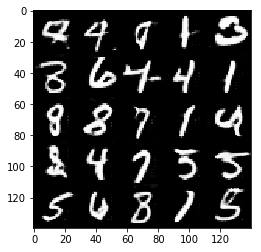

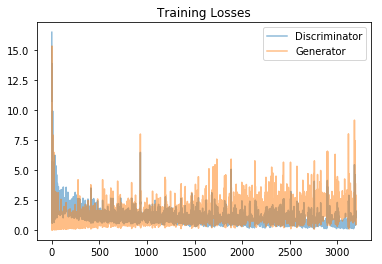

Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.4041
Epoch 2/2... Discriminator Loss: 0.4859... Generator Loss: 2.8682
Epoch 2/2... Discriminator Loss: 0.1870... Generator Loss: 2.9337
Epoch 2/2... Discriminator Loss: 0.1655... Generator Loss: 2.7048
Epoch 2/2... Discriminator Loss: 0.4412... Generator Loss: 1.7067
Epoch 2/2... Discriminator Loss: 0.1428... Generator Loss: 2.3583
Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 1.5795
Epoch 2/2... Discriminator Loss: 0.3035... Generator Loss: 2.5173
Epoch 2/2... Discriminator Loss: 0.1938... Generator Loss: 3.1813
Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.7310
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


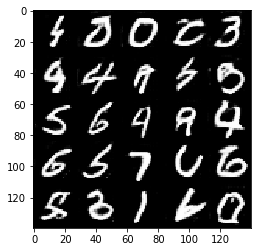

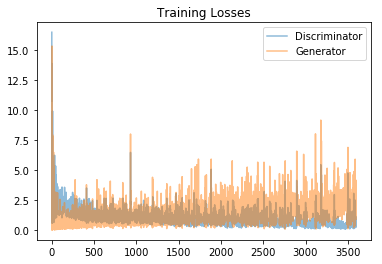

Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 0.5784... Generator Loss: 1.9259
Epoch 2/2... Discriminator Loss: 0.2511... Generator Loss: 2.5458
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 1 False
1


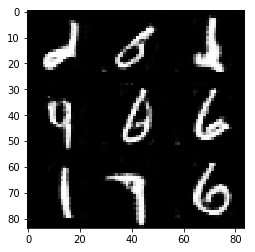

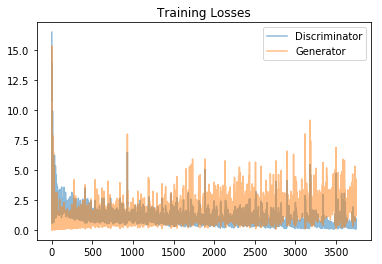

In [120]:
batch_size = 32
z_dim = 1024
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

model_inputs 28 28 3 1024
model_loss Tensor("input_real:0", shape=(?, 28, 28, 3), dtype=float32) Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 True
3
g_model Tensor("generator/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)
discriminator Tensor("input_real:0", shape=(?, 28, 28, 3), dtype=float32) False
discriminator Tensor("generator/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) True
===== Tensor("input_real:0", shape=(?, 28, 28, 3), dtype=float32)
model_opt Tensor("add:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) 0.0005 0.1
batch_size 32
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 3.0443... Generator Loss: 6.4095
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 3.8857... Generator Loss: 0.0428
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.6393
Epoch 1/1... Discriminator 

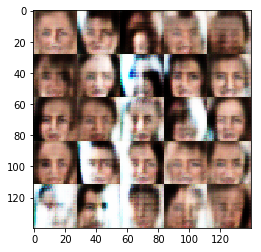

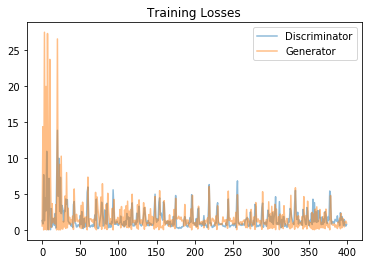

Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.9742
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 2.1392... Generator Loss: 0.1760
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.3310
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.6968... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 1.8078
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


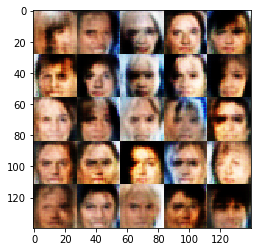

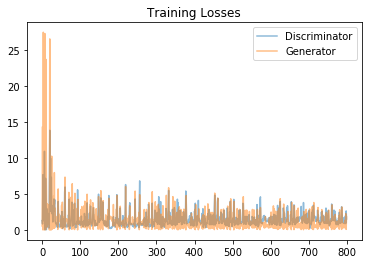

Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 2.1661... Generator Loss: 2.5690
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.8403
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.7413... Generator Loss: 2.8668
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 1.9773... Generator Loss: 0.2282
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 0.6888
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


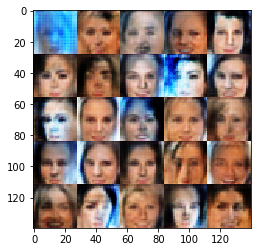

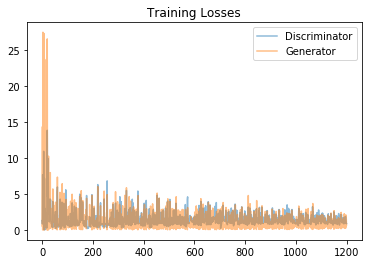

Epoch 1/1... Discriminator Loss: 1.9385... Generator Loss: 3.2140
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 2.1205... Generator Loss: 0.1653
Epoch 1/1... Discriminator Loss: 1.7696... Generator Loss: 0.3244
Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.2035
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.6818
Epoch 1/1... Discriminator Loss: 2.5206... Generator Loss: 2.7161
Epoch 1/1... Discriminator Loss: 2.0069... Generator Loss: 0.1710
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 2.1691... Generator Loss: 0.1490
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


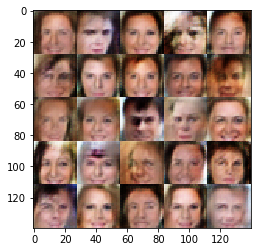

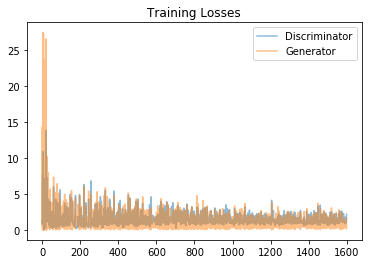

Epoch 1/1... Discriminator Loss: 2.5042... Generator Loss: 0.1368
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.3540
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.8901
Epoch 1/1... Discriminator Loss: 1.7336... Generator Loss: 0.2983
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.2761
Epoch 1/1... Discriminator Loss: 1.6345... Generator Loss: 0.3475
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


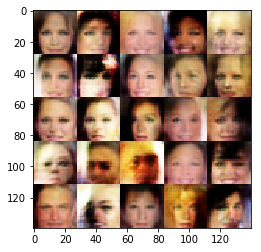

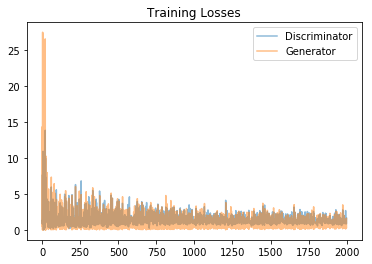

Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.7872... Generator Loss: 0.2375
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 1.8888
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 2.7570... Generator Loss: 2.8955
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 0.9787
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


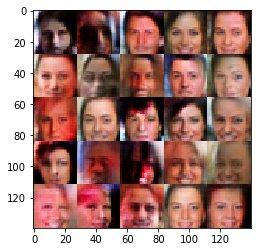

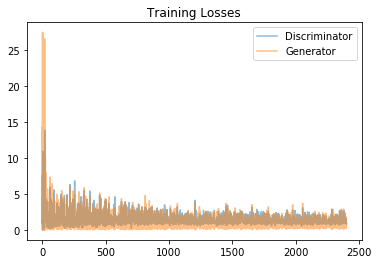

Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 1.8176
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.5595
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.3364
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


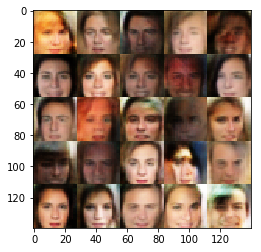

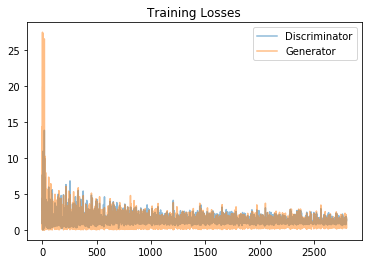

Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 0.2816
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 3.0377... Generator Loss: 3.5645
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 2.2299
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 2.0651
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.5311
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.9537
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.7001
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


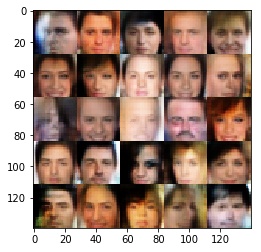

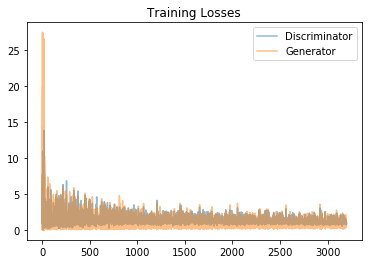

Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 2.4846
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 2.6711
Epoch 1/1... Discriminator Loss: 2.1766... Generator Loss: 0.1567
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.6889
Epoch 1/1... Discriminator Loss: 1.8134... Generator Loss: 0.2972
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


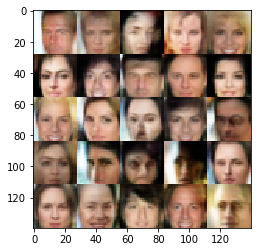

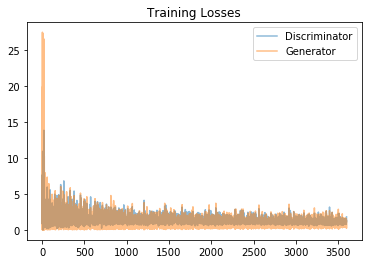

Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 2.2333
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.6949
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


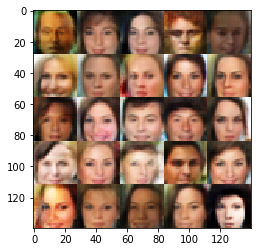

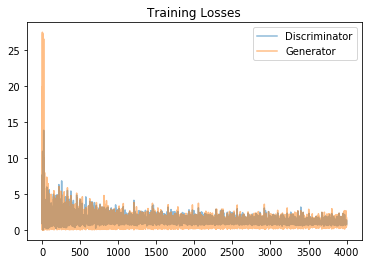

Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.3015
Epoch 1/1... Discriminator Loss: 1.9071... Generator Loss: 0.2927
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 1.8001
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.9793... Generator Loss: 0.2087
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 1.9974
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


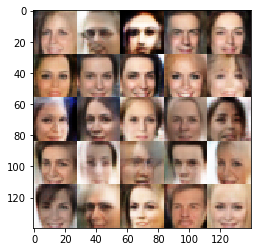

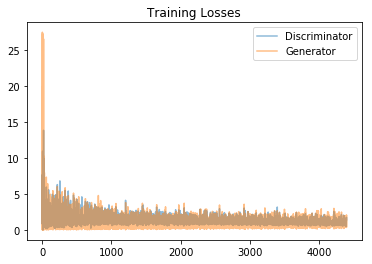

Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 1.8361
Epoch 1/1... Discriminator Loss: 1.8522... Generator Loss: 0.2761
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 2.5713
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 0.8996
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


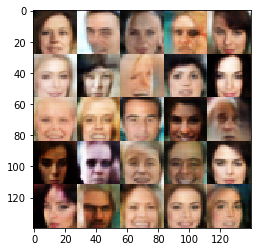

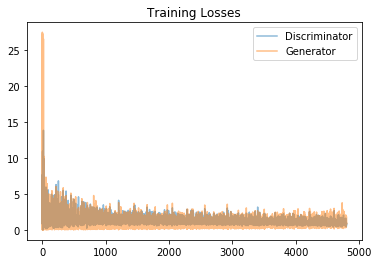

Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 2.0177
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 1.8150... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 2.0258
Epoch 1/1... Discriminator Loss: 1.6907... Generator Loss: 3.2565
Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 0.3032
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 2.1600... Generator Loss: 0.2392
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


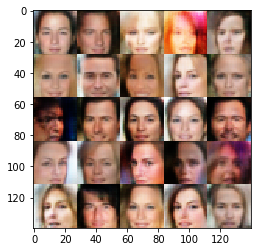

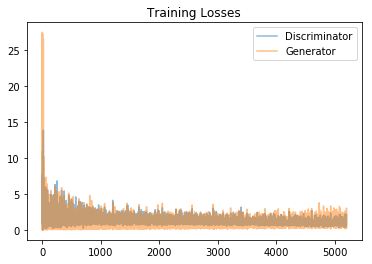

Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.9784
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.7412
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 3.8391
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 1.8081
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.5912
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


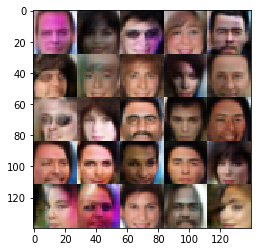

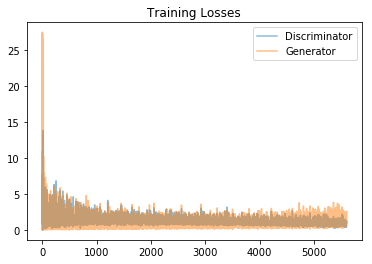

Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 2.1655
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.7785
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.3375
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 2.5176
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 0.7264
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


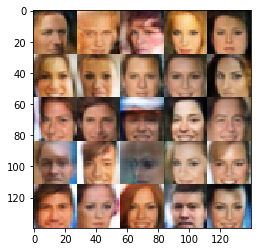

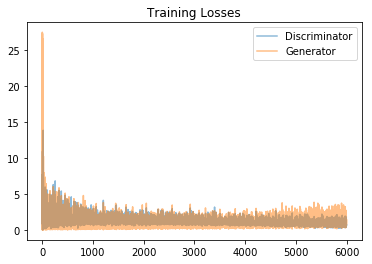

Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 2.3979
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 0.8156
generator Tensor("input_z:0", shape=(?, 1024), dtype=float32) 3 False
3


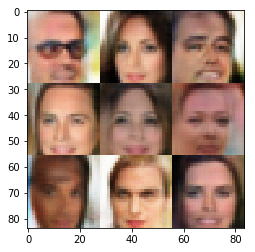

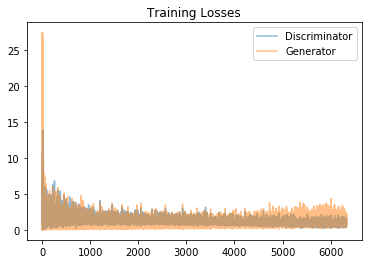

In [121]:
batch_size = 32
z_dim = 1024
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.